<a href="https://colab.research.google.com/github/yueliyl/mixehr-seed-tut/blob/main/MixEHR_Seed_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align="center">Inference of phenotype topics from EHR data using MixEHR-Seed</h2>

**Original Author**: Ziyang Song modfied by Yue Li

In this notebook, we provide a tutorial for running MixEHR-Seed model on electronic health record (EHR) data.

MixEHR-Seed is a expert-guided topic model trained on multi-modal EHR data. The Key content includes

1. **Process UKB EHR data**

2. **Topic models for EHR**

3. **Existing models and limitations**

4. **Run MixEHR-Seed model**

Please find the link: **github.com/li-lab-mcgill/MixEHR_Seed_Tutorial**

[Li Lab Page](https://www.cs.mcgill.ca/~yueli/research.html) | [Paper](https://dl.acm.org/doi/10.1145/3534678.3542675) | [Project Code](https://github.com/li-lab-mcgill/MixEHR-Seed) | [Jupyter Notebook](https://github.com/li-lab-mcgill/MixEHR_Seed_Tutorial/blob/main/MixEHR_Seed_tutorial.ipynb)


# 1. Process UKB EHR Data

In UKB database, phenotype and genotype data available from 500k participants with 95% being white European descendant.

UKB dataset contains more than 4900 unique **fields** of phenotypic data:

* Each field represents a type of data (ICD-10, ICD-9, OPCS, treatment)

* An example of variable is 41270-0.3

    - '41270' denotes a field, in this case, ICD-10 diagnostic codes
    
    - '0' denotes the patient's visit, in this case, the initial visit
    
    - '3' denotes the number of records, in this case, the third ICD-10 code
    
    - The variable '41270-0.3' represents the the third ICD-10 code recorded for the patient during the inital visit

* Within each visit, it does not distinguish date

    -  '41270-0.1' and  '41270-0.3' do not have sequential relationship

<img src="https://github.com/yueliyl/mixehr-seed-tut/blob/main/images/UKB_fields.png?raw=1" alt="UKB_fields" style="float: left;" width="400"/>

### Process multi-modal UKB EHR Data:

1. International Classification of Diseases (ICD) 10 diagnostic codes: Field #41270
2. Medication as Anatomical Therapeutic Chemical (ATC) codes, Field #20003
3. Classification of Interventions and Procedures (OPCS-4) codes, Field #41272

## 1.1 Process ICD-10 Codes

In the **Field #41270**, UKB database contains patient records of ICD-10 codes.

* An example of ICD-10 code is 'S86'
* 'S' is disease category. S represents injury, poisoning and certain other consequences of external causes
* '86' is specific disease type. S86 represents Injury of muscle and tendon at lower leg level


UKB employs a horizontal format for its data, with each column representing a entry of ICD code:

* Up to 240 codes per patient, **do not have sequential relationship**
* Most individuals only have few codes, with 'Nan' filling the remaining slots
* This table is highly **sparse** as a marjorty of elements are 'Nan'

| eid     | 41270-0.0 | 41270-0.1 | .... | 41270-0.240 |
|---------|-----------|-----------|------|-------------|
| 1000120 | S86    | K78       | .... | Nan   |
| 1000121 | I789    | Nan       | .... | Nan   |


We transform into the vertical format:

* The UKB database only has a single visit, each ICD-10 code only occurs once

| eid     | ICD-10 | Freq |
|---------|--------|----|
| 1000120 | S86   | 1 |
| 1000120 | K78    | 1 |
| 1000120 | ....   | 1 |
| 1000121 | I789   | 1 |

We extracted 5.9M ICD-10 codes from the UKBB participants



### Link ICD-10 codes to Phecodes

To employ the MixEHR-Seed model, we will need to link the ICD-10 codes to corresponding Phenotype Codes (Phecodes) using the [PheWAS](https://phewascatalog.org/phecodes_icd10) system.

Each disease is defined by a phecode, which corresponds to a set of related ICD codes.

| Disease | Phecode| ICD-10 |
|----------|----------|-------------|
| Asthma  | 495   | J45, ... |
| COPD    | 496.2   | J41, J42, ... |
| ...     | ...     | ...         |

We map each ICD code to its associated a Phecode (a specific phenotype):

* A total of 9505 ICD-10 codes are mapped to Phecodes
* 5M ICD-10 codes can be mapped to Phecodes.

| eid     | ICD-10 | Phecode | Freq |
|---------|--------|---------| ----|
| 1000120 | S86    |   1009  | 1 |
| 1000120 | K78    |   Nan   | 1 |
| 1000120 | ....   | ....    | 1 |
| 1000121 | I789   |   448   | 1 |


## 1.2 Process UKB Medication Codes

In the **Field #20003**, UKB database contains patient records of treatment/medication.

| eid     | 20003-0.0   | 20003-0.1   | .... |
|---------|-------------|-------------|------|
| 1000120 | 1140861958  | 1141188146  | .... |
| 1000121 | 1140868226  | 1140876358  |  .... |

UKB database assigns different codes to **varied dosages and different names** of the same medication.

* Hinder model to understand drug information.


| UKB med   | Meaning             |
|-----------|-----------------------------|
| 1140861958 | Simvastatin |
| 1141188146 | Simvador 10mg tablet |
| 1140868226 | Aspirin          |
| 1140876358 | Unguentum cocois co |


### Map UKB medication code to ATC code

The study referenced in [1] provides a mapping between UKB medication codes and ATC codes, which is detailed in the [supplementary material](https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-019-09572-5/MediaObjects/41467_2019_9572_MOESM3_ESM.xlsx).

* ATC codes group same active substances that acts on same organ/system

This mapping aligns 6,745 UKB medication codes with 885 distinct ATC codes.

| eid     | UKB med  | ATC |
|---------|------------|----------|
| 1000120 | 1140861958 | C10AA01  |
| 1000120 | 1141188146 | C10AA01  |
| 1000121 | 1140868226 | A01AD05  |
| 1000121 | 1140876358 | Nan  |


Since multiple medication codes can be mapped to a same ATC code, we compute the frequency of ATC codes for each indivudial.

* Rows with ATC code of 'NaN' were excluded from this aggregation


| eid     | UKB med  | ATC | Freq |
|---------|------------|----------|------|
| 1000120 | 1140861958 | C10AA01  | 2    |
| 1000121 | 1140868226 | A01AD05  | 1    |
| ...     | ...        | ...      | ...  |

[1] Wu, Y., Byrne, E.M., Zheng, Z. et al. Genome-wide association study of medication-use and associated disease in the UK Biobank. Nat Commun 10, 1891 (2019). https://doi.org/10.1038/s41467-019-09572-5

## 1.3 Process OPCS Codes

In the **Field #41272**, UKB database contains patient records of OPCS-4 procedure codes

It encodes operations, procedures, and interventions performed during in-patient stays, day case surgery, and some outpatient treatments in NHS hospitals. OPCS-4 code will have maximum 1 decimal place.

* An example of OPCS code is 'A01.1', a surgery that removes disease half of the brain
* 'A' is the Chapter. 'A' represents Nervous system
* '01' the Types of procedure. '01' is Major excision of tissue of brain
* '.1' is the Exact procedure. '.1'  is Hemispherectomy

| eid     | 41272-0.0   | 41272-0.1   | .... |
|---------|-------------|-------------|------|
| 1000120 | A042  | E018 | .... |
| 1000121 | B121  | NaN         |  .... |

We identify 8403 OPCS-4 procedure codes. Similarly, we transform from horizontal to vertical format.

| eid     | OPCS-4 |
|---------|------------|
| 1000120 | A042 |
| 1000120 | E018 |
| 1000121 | B121 |


### Summary of EHR Pre-processing

Among 502K participants, 474K individuals with at least one available codes.

To remove rare codes, we filter out EHR codes by:
* Exclude all EHR codes with fewer than 10 occurrences
* Remove Phecodes with less than 1000 cases

The final EHR data contains 462K patients with:
* 6954 distinct ICD10 codes corresponding to 1502 Phecodes
* 885 distinct ATC codes
* 2560 distinct OPCS procedure codes

# 2. Topic Modeling for EHR

## 2.1 What are EHRs?

EHRs collect patients' **heterogenous** medical histories including

* Diagnosis (ICD code)
* Medication
* Procedure
* Lab test
* Doctor note


Key objectives of EHR modeling:

* **Prediction**: disease development, drug recommendation, mortality rate

* **Disease Interpretability**: understanding disease representations, comorbidity, disease progression

<img src="https://github.com/yueliyl/mixehr-seed-tut/blob/main/images/EHR_data_time.png?raw=1" alt="EHR_data_time" style="float: left;" width="800"/>



## 2.2 What is Topic Modeling?

Topic models are probabilistic models that learn **topics** within a collection of documents.

* Each document contains multiple words
* **Each topic is a distribution of words that frequently occur together**
* Each document exhibits different probabilties for topics

Outputs of topic models:

*   Topic representation: a Topic X Vocabulary matrix, each topic is a distribution over words
*   Document-topic proportion: a Document X Topic matrix, each document is a distribution of topics


<img src="https://github.com/yueliyl/mixehr-seed-tut/blob/main/images/topic_model.png?raw=1" alt="topic_model" style="float: left;" width="800"/>


## 2.3 Apply Topic Models to EHR Data

What is document, word, topics in EHR data?

* Each patient’s medical history is a 'document'
* Diagnoses (ICD diagnostic codes) are 'words' within a document
* Disease is considered as a 'topic'


Topic models learn the co-occurence of words and outpusts:

* **Disease topic representation**: each disease topic is a distribution of diagnoses
    - Cardiovascular disease topic has frequent heart failure diagnoses
* **Patient-topic proportion**: the distribution of disease topics for each patient, the probability of a disease topic can be viewed as disease risk
    - A patient has high disease risk scores for hypertension, cardiovasular disease,...

Topic models do not distinguish the word sequence in a document:

* Learn topics from word co-occurence (counts) but sequential relationship
* Require probabilistic way for longitudinal analysis

<img src="https://github.com/yueliyl/mixehr-seed-tut/blob/main/images/EHR_modeling.png?raw=1" alt="EHR_modeling" style="float: left;" width="800"/>


# Clone github repo for accessing the data

In [1]:
# Clone your GitHub repo
!git clone https://github.com/yueliyl/mixehr-seed-tut.git

Cloning into 'mixehr-seed-tut'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 157 (delta 49), reused 129 (delta 28), pack-reused 0 (from 0)
Receiving objects: 100% (157/157), 15.72 MiB | 6.79 MiB/s, done.
Resolving deltas: 100% (49/49), done.


# 3. Existing Models and Limitations


## 3.1 Use MIMIC-III Subset Data

The MIMIC-III dataset is a publicly-available clinical data related to a diverse patient population managed in critical care units.

We selected a 1% subset of MIMIC data containing **ICD-9 codes** for running the LDA model.

In [2]:
import pandas as pd
data = pd.read_csv('mixehr-seed-tut/data/icd_toy_data_lda.csv')
data

,SUBJECT_ID,ICD9,FREQ
0,53192,49320,1
1,27098,49390,1
2,4647,49390,1
3,29274,49322,1
4,1200,49320,1
...,...,...,...
3595,57708,29580,1
3596,25038,29570,1
3597,72461,29590,1
3598,2945,29570,1


The dataset contains 3,427 patients and 3,600 ICD records (139 unique ICD codes)

In [3]:
# Count the unique number of patients
unique_patients_count = data['SUBJECT_ID'].nunique()
# Count the unique number of ICD-9 codes
unique_icd_codes_count = data['ICD9'].nunique()

# Output the results
print(f"Unique number of patients: {unique_patients_count}")
print(f"Unique number of ICD-9 codes: {unique_icd_codes_count}")

Unique number of patients: 3427
Unique number of ICD-9 codes: 139


## 3.2 Latent Dirichlet Allocation (LDA)

LDA is a classic topic model designed for single-modality data.

* Only learns ICD codes

We utilize the 'sklearn' library for LDA's implementation.

* Pre-determine topic number as 10

In [4]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10, random_state=0) # topic number (n_components) is 10

### Bag-of-word input

The input of LDA is a Bag-of-words matrix (Document X Vocabulary), where each element is the frequency of a ICD codes for a patient

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

# Group the ICD9 codes and convert them into a document for each patient
data['ICD9'] = data['ICD9'].astype(str)
documents = data.groupby('SUBJECT_ID')['ICD9'].apply(lambda icd_codes: ' '.join(icd_codes)).reset_index(name='document')

# Vectorize the ICD9 code documents
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(documents['document'])

print("Transform into an input of Bag-of-words matrix (Document X Vocabulary):", X.shape)

Transform into an input of Bag-of-words matrix (Document X Vocabulary): (3427, 139)


In [6]:
# Apply LDA to fit the Bag-of-words matrix
lda.fit(X)

LatentDirichletAllocation(random_state=0)

In [7]:
import numpy as np

# Topic proportion for all documents
topic_proportions = lda.transform(X)

# Topic representation (word distributions for each topic)
topic_distribution = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

# Print the shape of the topic distribution
print("Shape of topic representation is (Topic X Vocabulary):", topic_distribution.shape)

# Print the shape of the topic proportions
print("Shape of topic proportions is (Document X Topic):", topic_proportions.shape)

Shape of topic representation is (Topic X Vocabulary): (10, 139)
Shape of topic proportions is (Document X Topic): (3427, 10)


## 3.3 Manually Interpret Disease Topic Representation

Since the learned topics are the distributions over ICD codes, we interpret each disease topic by showing the top 3 ICD codes.

In [8]:
# Load the ICD descriptions dataset
icd_descriptions = pd.read_csv('mixehr-seed-tut/data/D_ICD_DIAGNOSES.csv')

# Create a dictionary mapping ICD codes to their long descriptions
icd_to_description = pd.Series(icd_descriptions['LONG_TITLE'].values, index=icd_descriptions['ICD9_CODE']).to_dict()

# Assuming 'lda' is your trained LDA model and 'vectorizer' is the CountVectorizer
feature_names = vectorizer.get_feature_names_out()
word_distributions = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

# Map the top words to their descriptions for each topic
top_descriptions_per_topic = []
for topic_idx, word_distribution in enumerate(word_distributions):
    top_icd_indices = word_distribution.argsort()[-3:][::-1]  # Get indices of the top words
    top_icd_codes = [feature_names[i] for i in top_icd_indices]
    top_icd_descriptions = [icd_to_description.get(icd_code, 'Unknown Diagnosis') for icd_code in top_icd_codes]
    top_descriptions_per_topic.append(top_icd_descriptions)

# Print out the top descriptions for each topic
for idx, descriptions in enumerate(top_descriptions_per_topic):
    print(f"Topic {idx+1}:")
    for description in descriptions:
        print(description)
    print("\n")

Topic 1:
Human immunodeficiency virus [HIV] disease
Schizoaffective disorder, unspecified
Obstructive chronic bronchitis with (acute) exacerbation


Topic 2:
Hypertensive chronic kidney disease, unspecified, with chronic kidney disease stage I through stage IV, or unspecified
Hypertensive chronic kidney disease, unspecified, with chronic kidney disease stage V or end stage renal disease
Chronic diastolic heart failure


Topic 3:
Chronic airway obstruction, not elsewhere classified
Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled
Subendocardial infarction, initial episode of care


Topic 4:
Unspecified essential hypertension
Unknown Diagnosis
Paranoid type schizophrenia, unspecified


Topic 5:
Epilepsy, unspecified, without mention of intractable epilepsy
Grand mal status
Diabetes with renal manifestations, type II or unspecified type, not stated as uncontrolled


Topic 6:
Coronary atherosclerosis of native coronary artery
Chroni

### Plot heatmap to interpret topics

For each of the 10 disease topics, we display the 3 highest-scoring ICD codes associated with each topic.

* Check the top ICD codes for each disease topic to determine its meaning

[0, 38, 114, 68, 69, 106, 128, 1, 81, 65, 138, 31, 58, 49, 9, 92, 121, 103, 98, 36, 93, 130, 134, 44, 118, 137, 62, 123, 136, 125]


/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)


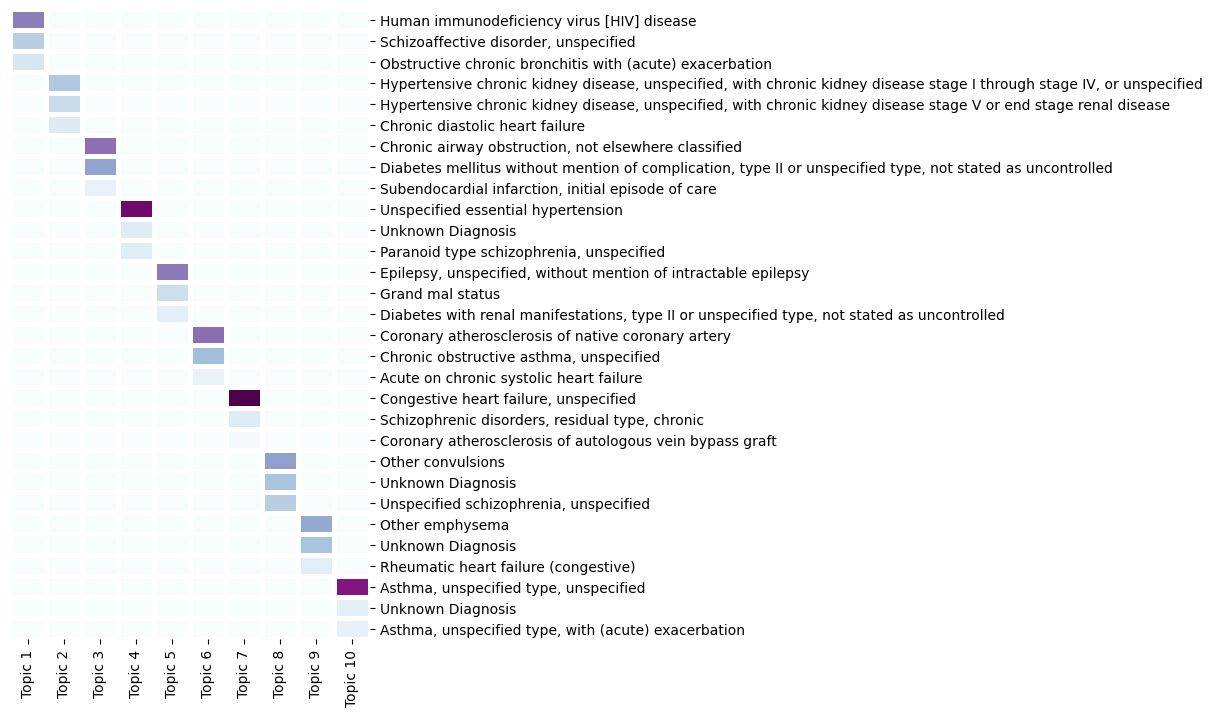

Each row is a ICD codes
Each column is a disease topic
A darker shade indicates a higher probability


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

num_top_words = 3
topics = 10

# Load the ICD descriptions dataset
icd_descriptions = pd.read_csv('mixehr-seed-tut/data/D_ICD_DIAGNOSES.csv')
icd_to_description = pd.Series(icd_descriptions['LONG_TITLE'].values, index=icd_descriptions['ICD9_CODE']).to_dict()

def truncate_description(description, max_words=5):
    """ Truncate the description to the specified number of words. """
    words = description.split()
    if len(words) > max_words:
        return ' '.join(words[:max_words]) + '...'
    return description

# Assuming 'lda' is your trained LDA model and 'vectorizer' is the CountVectorizer
feature_names = vectorizer.get_feature_names_out()
word_distributions = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

# Create an empty list to collect all top codes across all topics
all_top_icd_codes = []
all_top_icd_codes_indices = []

# Matrix to hold the probabilities of top codes per topic
topic_probs = np.zeros((num_top_words * topics, topics))

for topic_idx, word_distribution in enumerate(word_distributions):
    top_indices = word_distribution.argsort()[-num_top_words:][::-1]
    top_codes = [feature_names[i] for i in top_indices]
    all_top_icd_codes.extend(top_codes)
    all_top_icd_codes_indices.extend(top_indices)

print(all_top_icd_codes_indices)
topic_prob = word_distributions.transpose()[all_top_icd_codes_indices,:]
# Check the shape of the topic_probs to confirm it's 30x10

# Remove any duplicate ICD codes to ensure unique rows
unique_icd_codes = list(set(all_top_icd_codes))
unique_icd_codes.sort(key=all_top_icd_codes.index)  # Preserve the original order as much as possible

# Map ICD codes to descriptions and truncate if necessary
icd_descriptions = [truncate_description(icd_to_description.get(code, "Unknown Diagnosis"), 50) for code in unique_icd_codes]

# Create a DataFrame for the heatmap data
phi_data = pd.DataFrame(topic_prob, columns=[f"Topic {i+1}" for i in range(topics)], index=icd_descriptions)

# Define the maximum value for the color scale
max_value = np.max(topic_prob)

# Plotting the heatmap
g = sns.clustermap(phi_data, row_cluster=False, col_cluster=False, vmax=max_value, vmin=0,
                   linewidths=2.5, cmap="BuPu", yticklabels=True, figsize=(4, 7))
g.cax.set_visible(False)
g.ax_heatmap.set_position([0.05, 0.05, 0.9, 0.9])  # x, y, width, height
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
plt.show()

print('Each row is a ICD codes')
print('Each column is a disease topic')
print('A darker shade indicates a higher probability')


Topic 2: Chonic kidney disease

* Assign highest probabilities to Hypertensive Chronic Kidney Disease and Chronic Diastolic Heart Failure
* Chronic diastolic heart failure is known to be a common comorbidity associated with hypertensive chronic kidney disease

Topic 10: Asthma

* Top ICD codes are asthma-related

Some topics are not interpretable, such as Topic 1
* Human immunodeficiency virus [HIV] disease
* Schizoaffective disorder, unspecified
* Obstructive chronic bronchitis with (acute) exacerbation

## 3.4 Interpret Document-topic Proportion

For each patient document, the LDA learns a distribution over topics (disease risk scores).

We observe the highest probability for topic 5, indicating the most severe disease risk.


In [10]:
import random
random_patient_index = random.randint(0, 1000)
patient_topic_distribution = lda.transform(X[random_patient_index:random_patient_index+1])

# Now, patient_topic_distribution contains the topic distribution for the selected patient
print(f"Topic distribution for patient at index {random_patient_index}:")
print(patient_topic_distribution)

Topic distribution for patient at index 595:
[[0.05 0.05 0.55 0.05 0.05 0.05 0.05 0.05 0.05 0.05]]


## 3.5 Limitations of Classic Topic Models


### Limitation 1. Require human interpretation

* Pre-define the number of topics
* Manually interpret learned topics to determine their meaning
* Require clinical knowledge to interpret topics


### Limitation 2. It only learns single modality (ICD codes)

* Medication, lab test, doctor note also help understand a patient's condition



## 3.6 Improvment of MixEHR-Seed
## Improvment 1: Phenotype-guided Topic Model

The [PheWAS](https://phewascatalog.org/phecodes) is expert-defined mapping system for disease categorization.

Each disease is defined by a phenotype code (phecode), which corresponds to a set of related ICD codes.

| Disease | Phecode | ICD-9 |
|----------|----------|-------------|
| Asthma  | 495.2   | 493.x, ... |
| COPD    | 496.2   | 491.x, ... |
| ...     | ...     | ...         |


### Incorporate PheWAS into topic modeling (MixEHR-Seed)

View each phecode as a  pre-established disease topic, which is linked to a group of **seed** ICD codes.

MixEHR-Seed model learns regular topic and seed topic:

* Each **regular** topic corresponds to a standard topic in LDA, the distributions across all ICD codes
* Each **seed** toipc is distributed only over its **seed** ICD codes, reflecting expert knowledge


When encounter ICD codes (493.xx), it assigns a higher weight for disease topic (495.2 asthma).

<img src="https://github.com/yueliyl/mixehr-seed-tut/blob/main/images/seed_guidance_approach.png?raw=1" alt="seed_guidance_approach" style="float: left;" width="800"/>



Less reliance on manual interpretation:

* Do not require pre-defined topic number
* Pre-establish topic meaning
* Incorporate expert-defined PheWAS categorization directly into model

## Improvment 2. Include Multi-modal MIMIC Data

The EHRs in MIMIC dataset include six **heterogenous** modelities:

* ICD
* Prescription
* Diagnosis-related group (DRG)
* Current Procedural Terminology (CPT)
* Lab test
* Doctor notes

where only ICD modality is guided by PheWAS.


In [11]:
icd_data = pd.read_csv('mixehr-seed-tut/data/icd_toy_data.csv')
icd_data.head(3)

,SUBJECT_ID,HADM_ID,ICD9,PheCode,FREQ
0,53192,123631,49320,495.1,1
1,27098,152184,49390,495.0,1
2,4647,141820,49390,495.0,1


In [12]:
pres_data = pd.read_csv('mixehr-seed-tut/data/pres_toy_data.csv')
pres_data.head(3)

,SUBJECT_ID,COMPOUND_ID,FREQ
0,7981,Neutra-Phos-Neutra-Phos-016905-17314931102,3
1,12080,Heparin-Heparin Sodium-006549-00641040025,1
2,69426,Gabapentin-Gabapentin-021413-68084007965,2


# 4. Run MixEHR-Seed Model

MixEHR-Seed improves over classic topic model in two aspects:

* Improvement 1: use PheWAS-guidance about expert-defined phenotypes to learn meaningful disease topics
* Improvement 2: includes multiple data types to learn multi-modal disease topics


Outputs of MixEHR-Seed model:

*   Disease topic representation: For each data type, the disease topic is a distrubtion of words (ICD, medications,...)
*   Patient-topic proportion: Each patient has a distribution of disease topics, indicating disease risk scores

## Step 1: Process Dataset and Extract Seeds


### Prepare data

The EHR data is located in the `./data` directory.

* **Mandatory ICD code**.
Headers:, ICD9, Phecode, Freq


| SUBJECT_ID | ICD9  | Phecode | Freq |
|------------|-------|---------|------|
| 53192      | 49320 | 495.10  | 1    |
| 27098      | 49390 | 494.00  | 2    |
| ...        | ...   | ...     | ...  |

* **Any other types** as complementary information, such as medication.


| SUBJECT_ID | ***type_name***   | Freq |
|------------|-------|------|
| 7981      | Neutra-Phos | 1    |
| 12080      | Heparin | 2    |
| ...        | ...   | ...  |


### Process data

This procedure generates a ***Corpus*** object that can be executed by the MixEHR-Seed model. To generate and save the processed corpus in the `./store` directory, execute the `./corpus.py` with the following command:

```
run(parser.parse_args(['process', '-n', '150', './data/', './store/']))
```

In [13]:
%run mixehr-seed-tut/corpus.py process -n 150 mixehr-seed-tut/data/ mixehr-seed-tut/store/

mixehr-seed-tut/data/
mixehr-seed-tut/store/
                           path  word_column
index                                       
icd     ./data/icd_toy_data.csv         ICD9
pres   ./data/pres_toy_data.csv  COMPOUND_ID
cpt     ./data/cpt_toy_data.csv    ICD9_CODE
drg     ./data/drg_toy_data.csv  COMPOUND_ID
lab     ./data/lab_toy_data.csv        LABEL
note   ./data/note_toy_data.csv         TERM
['icd', 'pres', 'cpt', 'drg', 'lab', 'note']
{'icd': './data/icd_toy_data.csv', 'pres': './data/pres_toy_data.csv', 'cpt': './data/cpt_toy_data.csv', 'drg': './data/drg_toy_data.csv', 'lab': './data/lab_toy_data.csv', 'note': './data/note_toy_data.csv'}
{'icd': 'ICD9', 'pres': 'COMPOUND_ID', 'cpt': 'ICD9_CODE', 'drg': 'COMPOUND_ID', 'lab': 'LABEL', 'note': 'TERM'}


FileNotFoundError: [Errno 2] No such file or directory: './data/icd_toy_data.csv'

<Figure size 640x480 with 0 Axes>

## Step 2: Run An Informative Initialization (Optional)

To ensure a more informative starting point, we compute disease topic prior for patient topic proportion, guided by established phenotypes.
  
Executing the `./guide/prior/init_tokens.py` script, it saves initilized files in the `./guide_prior/init_tokens/` directory.

* Aggregate phenotype data
* Assign appropriate priors
* Compute intialized values

<img src="https://github.com/yueliyl/mixehr-seed-tut/blob/main/images/guide_patient_topic_mixture.png?raw=1" alt="guide_patient_topic_mixture" style="float: left;" width="800"/>


In [16]:
%run mixehr-seed-tut/guide_prior/init_tokens.py

Failed to run ../guide_prior/get_doc_phecode.py: Command '['python', '../guide_prior/get_doc_phecode.py']' returned non-zero exit status 2.
python3: can't open file '/content/../guide_prior/get_doc_phecode.py': [Errno 2] No such file or directory

Failed to run ../guide_prior/get_prior_GMM.py: Command '['python', '../guide_prior/get_prior_GMM.py']' returned non-zero exit status 2.
python3: can't open file '/content/../guide_prior/get_prior_GMM.py': [Errno 2] No such file or directory

Failed to run ../guide_prior/get_token_counts.py: Command '['python', '../guide_prior/get_token_counts.py']' returned non-zero exit status 2.
python3: can't open file '/content/../guide_prior/get_token_counts.py': [Errno 2] No such file or directory



## Step 3: Run MixEHR-Seed Model

To apply seed-guided topic modeling to the processed corpus, we execute the `./main.py` file.

This code read corpus file from the `./store/` and outputs variables within the  `./parameters/`.


```
run(parser.parse_args(['./store/', './parameters/']))
```   

In [ ]:
%run ./main.py

## Step 4: Evalution

The outputs are saved at ./parameters/, we can evaluate the topic interpretability and phenotype prediction.

We plot the heatmap by showing the top 3 ICD codes for each topic

* **Use regular topic instead of seed topic**

In [ ]:
%cd ./plot
%run ./Heatmap_ICD.py
%cd ..

## Interpret the ICD Heatmap

For each of the nine chosen phenotypes, we display the three highest-scoring ICD codes associated with each topic:

* Each row is a ICD codes
* Each column is a disease topic
* A darker shade  indicates a higher probability.
* The sidebar indicates if a top ICD code is identified as a associated ICD code (highlighted in yellow) for its respective topic.

Results:

* Most of ICD codes are seed codes for their topics
* Most of ICD codes are related to disease topics. For example, top 3 ICD codes are asthma-related codes for topic 495 (asthma)

<img src="https://github.com/yueliyl/mixehr-seed-tut/blob/main/images/ICD.png?raw=1" alt="ICD" style="float: left;" width="600"/>

In [ ]:
%cd ./plot
%run ./Heatmap_Prescription.py
%cd ..


## Interpret the Prescription Heatmap

For each of the nine chosen phenotypes, we display the three highest-scoring **drugs** associated with each topic.

* Each row is a medication
* Each column is a disease topic
* A darker shade indicates a higher probability.

Although prescription modality is not guided, it is still interpretable:

* Top drug insulin are frequently occured in phenotype topic 250 (Diabetes)
* Top drug metoprolol are frequently observed in Ischemic heart disease (IHD)metoprolol lowers blood pressure and heart rate

Remember topic models learn co-occurence of words...

* Corrletaion does not imply causality

<img src="https://github.com/yueliyl/mixehr-seed-tut/blob/main/images/medication.png?raw=1" alt="medication" style="float: left;" width="400"/>

## Plot Heatmaps for Other Modalities

You can also plot the disease topics for other modalities over different codes:

* APT modelity: `./plot/Heatmap_APT/`
* DRG modelity: `./plot/Heatmap_DRG/`
* Lab test modelity: `./plot/Heatmap_labtest/`
* Doctor note modelity: `./plot/Heatmap_note/`

## Automatic Phenotyping by MixEHR-Seed

The patient-topic proportion can be used for automatic phenotyping:

* MixEHR-Seed learns a Patient X Phenotypes (topics) matrix, and each element represents the disease risk for a patient.

* For each phenotype topic, the patients are assigned with low-risk and high-risk scores

* MixEHR-Seed allows to predict thousands of phenotypes simultaneously

<img src="https://github.com/yueliyl/mixehr-seed-tut/blob/main/images/topic_mixture.png?raw=1" alt="topic_mixture" style="float: left;" width="700"/>


## Example of Inferred Probability

We randomly select patients and show the occurence of phecodes (left) and the learned probabilities (right):

* The phecode occurence (left) only gives us **counts**, while MixEHR-Seed provides learned **probabilities**
* The model will adjust probabilities from the correlation between phenotypes

<img src="https://github.com/yueliyl/mixehr-seed-tut/blob/main/images/prediction.png?raw=1" alt="prediction" style="float: left;" width="700"/>

## Phenotype-specific Longitudinal Analysis


Model the popluation-level longitudinal progression of phenotype $k$:
- Use disease risk scores $\Theta$ to predict disease outcome for $d$-th patient:


$$
  y_{d,k} =
  \begin{cases}
  1, & \text{if } \Theta_{d,k} \geq \tau \\
  0, & \text{if } \Theta_{d,k} < \tau
  \end{cases}
$$

- For an 5-year age interval $t$, we compute prevalence by dividing $S_t$ (the number of patients at age group $t$):

  $$
  \rho_{k,t} = \frac{\sum_{d \in t} y_{d,k}}{S_{t}}
  $$

- Normalize relative prevalence over time:

$$  
    p_{k,t} = \frac{\rho_{k,t}}{\sum_{t'} \rho_{k,t'}}
$$

Example results for most age-dependent phenotypes referenced in [2]

* Use an advanced neural nework way to estimate the prevalence scores

[2] Ziyang Song, Yuanyi Hu, Aman Verma, David Buckeridge, and Yue Li. 2022. Automatic Phenotyping by a Seed-guided Topic Model. SIGKDD Conference on Knowledge Discovery and Data Mining (KDD), 2022.

<img src="https://github.com/yueliyl/mixehr-seed-tut/blob/main/images/temporal_new.png?raw=1" alt="temporal_new" style="float: left;" width="800"/>